## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import requests

Using TensorFlow backend.


<Response [200]>

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], use_bn=True, drp_ratio=0, l2_ratio=0):
    
    # input layer
    input_layer = keras.layers.Input(input_shape)
    
    # hidden layer
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer) # regularization
            
            x = Dropout(drp_ratio)(x) # Dropput
            if use_bn:
                x = BatchNormalization()(x) # BatchNormalization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x) # regularization
            x = Dropout(drp_ratio)(x) # Dropput
            if use_bn:
                x = BatchNormalization()(x) # BatchNormalization
    
    # output layer
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [9]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256

MOMENTUM = 0.95
"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0, 0.25, 0.5, 0.8]
L2_RATIO = [0, 1e-2, 1e-4]


In [10]:
# Collect results
import keras.backend as K
results = {}
for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    
    # clear_session
    K.clear_session()
    
    # build model
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    
    # compile
#   optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # fit
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}


Numbers of exp: 0, with bn: True, drp_ratio: 0.00, l2_ratio: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
___________________________________________________________

50000/50000 [==============================] - 2s 44us/step - loss: 0.2424 - accuracy: 0.9298 - val_loss: 2.3540 - val_accuracy: 0.4724
Epoch 44/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.2352 - accuracy: 0.9307 - val_loss: 2.2359 - val_accuracy: 0.4762
Epoch 45/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.2201 - accuracy: 0.9368 - val_loss: 2.3896 - val_accuracy: 0.4682
Epoch 46/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.2049 - accuracy: 0.9419 - val_loss: 2.3632 - val_accuracy: 0.4640
Epoch 47/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.1934 - accuracy: 0.9453 - val_loss: 2.3490 - val_accuracy: 0.4675
Epoch 48/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.1870 - accuracy: 0.9477 - val_loss: 2.3717 - val_accuracy: 0.4723
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.1789 - accuracy: 0.9508 - val_loss: 2.4795

50000/50000 [==============================] - 2s 46us/step - loss: 1.2204 - accuracy: 0.6851 - val_loss: 2.0862 - val_accuracy: 0.4269
Epoch 36/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2045 - accuracy: 0.6884 - val_loss: 2.1629 - val_accuracy: 0.4145
Epoch 37/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.2064 - accuracy: 0.6855 - val_loss: 2.2975 - val_accuracy: 0.3905
Epoch 38/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1950 - accuracy: 0.6880 - val_loss: 2.0859 - val_accuracy: 0.4675
Epoch 39/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1706 - accuracy: 0.6958 - val_loss: 2.7942 - val_accuracy: 0.3615
Epoch 40/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.1809 - accuracy: 0.6907 - val_loss: 2.2524 - val_accuracy: 0.3978
Epoch 41/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1705 - accuracy: 0.6945 - val_loss: 2.0406

50000/50000 [==============================] - 2s 45us/step - loss: 0.7010 - accuracy: 0.8124 - val_loss: 2.1144 - val_accuracy: 0.4514
Epoch 28/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6873 - accuracy: 0.8166 - val_loss: 1.9601 - val_accuracy: 0.4667
Epoch 29/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.6545 - accuracy: 0.8300 - val_loss: 1.9608 - val_accuracy: 0.4805
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6328 - accuracy: 0.8377 - val_loss: 2.0125 - val_accuracy: 0.4720
Epoch 31/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.6105 - accuracy: 0.8453 - val_loss: 2.1212 - val_accuracy: 0.4587
Epoch 32/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5876 - accuracy: 0.8525 - val_loss: 2.0276 - val_accuracy: 0.4739
Epoch 33/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5611 - accuracy: 0.8636 - val_loss: 2.0763

50000/50000 [==============================] - 2s 45us/step - loss: 1.4984 - accuracy: 0.4634 - val_loss: 1.4412 - val_accuracy: 0.4809
Epoch 20/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4856 - accuracy: 0.4687 - val_loss: 1.4429 - val_accuracy: 0.4830
Epoch 21/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4722 - accuracy: 0.4723 - val_loss: 1.4331 - val_accuracy: 0.4881
Epoch 22/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4690 - accuracy: 0.4697 - val_loss: 1.4239 - val_accuracy: 0.4884
Epoch 23/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.4662 - accuracy: 0.4746 - val_loss: 1.4069 - val_accuracy: 0.4976
Epoch 24/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4546 - accuracy: 0.4780 - val_loss: 1.4073 - val_accuracy: 0.4943
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4468 - accuracy: 0.4819 - val_loss: 1.4315

50000/50000 [==============================] - 2s 46us/step - loss: 4.3909 - accuracy: 0.4145 - val_loss: 4.1878 - val_accuracy: 0.3921
Epoch 12/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.9856 - accuracy: 0.4197 - val_loss: 3.7778 - val_accuracy: 0.4269
Epoch 13/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.6436 - accuracy: 0.4215 - val_loss: 3.4546 - val_accuracy: 0.4330
Epoch 14/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.3705 - accuracy: 0.4174 - val_loss: 3.1780 - val_accuracy: 0.4437
Epoch 15/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.1127 - accuracy: 0.4231 - val_loss: 2.9949 - val_accuracy: 0.4289
Epoch 16/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.8814 - accuracy: 0.4275 - val_loss: 2.7811 - val_accuracy: 0.4212
Epoch 17/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.7003 - accuracy: 0.4325 - val_loss: 2.5720

50000/50000 [==============================] - 2s 46us/step - loss: 1.9844 - accuracy: 0.3407 - val_loss: 1.8125 - val_accuracy: 0.3973
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.9083 - accuracy: 0.3648 - val_loss: 1.7885 - val_accuracy: 0.4090
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.8631 - accuracy: 0.3767 - val_loss: 1.7381 - val_accuracy: 0.4258
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.8274 - accuracy: 0.3919 - val_loss: 1.7297 - val_accuracy: 0.4317
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.8011 - accuracy: 0.4021 - val_loss: 1.6972 - val_accuracy: 0.4426
Epoch 8/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.7754 - accuracy: 0.4127 - val_loss: 1.6724 - val_accuracy: 0.4511
Epoch 9/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.7535 - accuracy: 0.4187 - val_loss: 1.6768 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.6060 - accuracy: 0.1584 - val_loss: 1.9931 - val_accuracy: 0.2715
Epoch 2/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.2165 - accuracy: 0.2178 - val_loss: 1.9393 - val_accuracy: 0.2961
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.0677 - accuracy: 0.2504 - val_loss: 1.8648 - val_accuracy: 0.3283
Epoch 4/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.9849 - accuracy: 0.2741 - val_loss: 1.8397 - val_accuracy: 0.3352
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.9426 - accuracy: 0.2909 - val_loss: 1.8339 - val_accuracy: 0.3399
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.9062 - accuracy: 0.3017 - val_loss: 1.7817 - val_accuracy: 0.3535
Epoch 7/50
50000/50000 [==============================] - 2s 46us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 54us/step - loss: 15.6390 - accuracy: 0.1531 - val_loss: 14.1145 - val_accuracy: 0.2324
Epoch 2/50
50000/50000 [==============================] - 2s 46us/step - loss: 13.3847 - accuracy: 0.2135 - val_loss: 12.3300 - val_accuracy: 0.2420
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 11.6057 - accuracy: 0.2485 - val_loss: 10.6933 - val_accuracy: 0.3089
Epoch 4/50
50000/50000 [==============================] - 2s 45us/step - loss: 10.1289 - accuracy: 0.2758 - val_loss: 9.4205 - val_accuracy: 0.3170
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 8.8870 - accuracy: 0.2950 - val_loss: 8.2782 - val_accuracy: 0.3307
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 7.8378 - accuracy: 0.3098 - val_loss: 7.2886 - val_accuracy: 0.3581
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.7748 - accuracy: 0.1530 - val_loss: 2.1861 - val_accuracy: 0.2524
Epoch 2/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.3884 - accuracy: 0.2064 - val_loss: 2.1354 - val_accuracy: 0.2653
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.2342 - accuracy: 0.2400 - val_loss: 2.0486 - val_accuracy: 0.3029
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.1501 - accuracy: 0.2642 - val_loss: 2.0202 - val_accuracy: 0.3252
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.0913 - accuracy: 0.2859 - val_loss: 1.9673 - val_accuracy: 0.3456
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.0528 - accuracy: 0.3008 - val_loss: 1.9697 - val_accuracy: 0.3379
Epoch 7/50
50000/50000 [==============================] - 2s 47us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.8583 - accuracy: 0.1026 - val_loss: 2.2767 - val_accuracy: 0.1103
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.5658 - accuracy: 0.1126 - val_loss: 2.2941 - val_accuracy: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.4085 - accuracy: 0.1195 - val_loss: 2.3067 - val_accuracy: 0.1001
Epoch 4/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.3170 - accuracy: 0.1337 - val_loss: 2.3232 - val_accuracy: 0.1026
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.2596 - accuracy: 0.1432 - val_loss: 2.3230 - val_accuracy: 0.1084
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.2182 - accuracy: 0.1542 - val_loss: 2.3203 - val_accuracy: 0.1138
Epoch 7/50
50000/50000 [==============================] - 2s 44us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 55us/step - loss: 15.9091 - accuracy: 0.1044 - val_loss: 14.3755 - val_accuracy: 0.1005
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 13.7415 - accuracy: 0.1106 - val_loss: 12.6212 - val_accuracy: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 11.9604 - accuracy: 0.1199 - val_loss: 11.1264 - val_accuracy: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 46us/step - loss: 10.4696 - accuracy: 0.1377 - val_loss: 9.8457 - val_accuracy: 0.1020
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 9.2088 - accuracy: 0.1530 - val_loss: 8.7531 - val_accuracy: 0.1083
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 8.1417 - accuracy: 0.1650 - val_loss: 7.7938 - val_accuracy: 0.1179
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.9572 - accuracy: 0.1036 - val_loss: 2.4261 - val_accuracy: 0.1236
Epoch 2/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.6851 - accuracy: 0.1113 - val_loss: 2.4363 - val_accuracy: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.5381 - accuracy: 0.1198 - val_loss: 2.4497 - val_accuracy: 0.1001
Epoch 4/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.4479 - accuracy: 0.1351 - val_loss: 2.4589 - val_accuracy: 0.1041
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3915 - accuracy: 0.1460 - val_loss: 2.4610 - val_accuracy: 0.1103
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.3527 - accuracy: 0.1555 - val_loss: 2.4555 - val_accuracy: 0.1176
Epoch 7/50
50000/50000 [==============================] - 2s 46us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.0067 - accuracy: 0.2828 - val_loss: 1.8440 - val_accuracy: 0.3535
Epoch 2/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7927 - accuracy: 0.3709 - val_loss: 1.7429 - val_accuracy: 0.3937
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7115 - accuracy: 0.4019 - val_loss: 1.6796 - val_accuracy: 0.4156
Epoch 4/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6525 - accuracy: 0.4218 - val_loss: 1.6366 - val_accuracy: 0.4165
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6050 - accuracy: 0.4367 - val_loss: 1.5923 - val_accuracy: 0.4467
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5666 - accuracy: 0.4499 - val_loss: 1.6000 - val_accuracy: 0.4415
Epoch 7/50
50000/50000 [==============================] - 2s 33us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 15.0816 - accuracy: 0.2789 - val_loss: 13.9463 - val_accuracy: 0.3513
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 13.0147 - accuracy: 0.3605 - val_loss: 12.1253 - val_accuracy: 0.3659
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 11.3432 - accuracy: 0.3829 - val_loss: 10.5954 - val_accuracy: 0.3921
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 9.9319 - accuracy: 0.3971 - val_loss: 9.2975 - val_accuracy: 0.3973
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 8.7322 - accuracy: 0.4080 - val_loss: 8.1906 - val_accuracy: 0.4104
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 7.7102 - accuracy: 0.4154 - val_loss: 7.2463 - val_accuracy: 0.4219
Epoch 7/50
50000/50000 [==============================] - 2s 3

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.1597 - accuracy: 0.2771 - val_loss: 2.0008 - val_accuracy: 0.3443
Epoch 2/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.9464 - accuracy: 0.3641 - val_loss: 1.8971 - val_accuracy: 0.3819
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.8678 - accuracy: 0.3940 - val_loss: 1.8435 - val_accuracy: 0.4008
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.8121 - accuracy: 0.4148 - val_loss: 1.7983 - val_accuracy: 0.4093
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.7648 - accuracy: 0.4304 - val_loss: 1.7533 - val_accuracy: 0.4285
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.7255 - accuracy: 0.4428 - val_loss: 1.7246 - val_accuracy: 0.4469
Epoch 7/50
50000/50000 [==============================] - 2s 35us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.1914 - accuracy: 0.1842 - val_loss: 2.0121 - val_accuracy: 0.2987
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.0123 - accuracy: 0.2640 - val_loss: 1.8992 - val_accuracy: 0.3331
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.9237 - accuracy: 0.3052 - val_loss: 1.8132 - val_accuracy: 0.3603
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.8699 - accuracy: 0.3267 - val_loss: 1.7698 - val_accuracy: 0.3758
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.8259 - accuracy: 0.3446 - val_loss: 1.7267 - val_accuracy: 0.3886
Epoch 6/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.7917 - accuracy: 0.3583 - val_loss: 1.6862 - val_accuracy: 0.4021
Epoch 7/50
50000/50000 [==============================] - 2s 34us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 40us/step - loss: 15.2160 - accuracy: 0.1911 - val_loss: 14.0498 - val_accuracy: 0.3038
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 13.1728 - accuracy: 0.2657 - val_loss: 12.2051 - val_accuracy: 0.3338
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 11.4812 - accuracy: 0.3005 - val_loss: 10.6570 - val_accuracy: 0.3486
Epoch 4/50
50000/50000 [==============================] - 2s 36us/step - loss: 10.0541 - accuracy: 0.3232 - val_loss: 9.3429 - val_accuracy: 0.3660
Epoch 5/50
50000/50000 [==============================] - 2s 36us/step - loss: 8.8424 - accuracy: 0.3381 - val_loss: 8.2310 - val_accuracy: 0.3814
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 7.8095 - accuracy: 0.3467 - val_loss: 7.2803 - val_accuracy: 0.3830
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.3449 - accuracy: 0.1845 - val_loss: 2.1425 - val_accuracy: 0.2997
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.1464 - accuracy: 0.2672 - val_loss: 2.0192 - val_accuracy: 0.3444
Epoch 3/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.0578 - accuracy: 0.3055 - val_loss: 1.9513 - val_accuracy: 0.3630
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.0039 - accuracy: 0.3305 - val_loss: 1.9045 - val_accuracy: 0.3728
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.9598 - accuracy: 0.3451 - val_loss: 1.8552 - val_accuracy: 0.3920
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.9250 - accuracy: 0.3582 - val_loss: 1.8202 - val_accuracy: 0.4057
Epoch 7/50
50000/50000 [==============================] - 2s 36us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.3232 - accuracy: 0.1276 - val_loss: 2.2272 - val_accuracy: 0.2412
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2079 - accuracy: 0.1759 - val_loss: 2.0909 - val_accuracy: 0.2615
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.1183 - accuracy: 0.2101 - val_loss: 2.0054 - val_accuracy: 0.2840
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.0617 - accuracy: 0.2319 - val_loss: 1.9500 - val_accuracy: 0.3051
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.0208 - accuracy: 0.2509 - val_loss: 1.9041 - val_accuracy: 0.3284
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.9906 - accuracy: 0.2656 - val_loss: 1.8760 - val_accuracy: 0.3434
Epoch 7/50
50000/50000 [==============================] - 2s 35us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 40us/step - loss: 15.3091 - accuracy: 0.1295 - val_loss: 14.2140 - val_accuracy: 0.2170
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 13.3134 - accuracy: 0.1723 - val_loss: 12.3555 - val_accuracy: 0.2432
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 11.6206 - accuracy: 0.2021 - val_loss: 10.7950 - val_accuracy: 0.2885
Epoch 4/50
50000/50000 [==============================] - 2s 36us/step - loss: 10.1905 - accuracy: 0.2272 - val_loss: 9.4716 - val_accuracy: 0.3047
Epoch 5/50
50000/50000 [==============================] - 2s 36us/step - loss: 8.9758 - accuracy: 0.2447 - val_loss: 8.3494 - val_accuracy: 0.3177
Epoch 6/50
50000/50000 [==============================] - 2s 36us/step - loss: 7.9411 - accuracy: 0.2622 - val_loss: 7.3912 - val_accuracy: 0.3247
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.4464 - accuracy: 0.1377 - val_loss: 2.3175 - val_accuracy: 0.2604
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.3114 - accuracy: 0.1862 - val_loss: 2.1948 - val_accuracy: 0.2780
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.2345 - accuracy: 0.2187 - val_loss: 2.1174 - val_accuracy: 0.2991
Epoch 4/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.1818 - accuracy: 0.2415 - val_loss: 2.0566 - val_accuracy: 0.3218
Epoch 5/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.1446 - accuracy: 0.2607 - val_loss: 2.0171 - val_accuracy: 0.3339
Epoch 6/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.1065 - accuracy: 0.2734 - val_loss: 1.9893 - val_accuracy: 0.3484
Epoch 7/50
50000/50000 [==============================] - 2s 36us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.4375 - accuracy: 0.1012 - val_loss: 2.3022 - val_accuracy: 0.1091
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.3033 - accuracy: 0.1014 - val_loss: 2.3022 - val_accuracy: 0.1067
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3032 - accuracy: 0.1023 - val_loss: 2.3024 - val_accuracy: 0.1046
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.3028 - accuracy: 0.1015 - val_loss: 2.3022 - val_accuracy: 0.1091
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3029 - accuracy: 0.0994 - val_loss: 2.3019 - val_accuracy: 0.1279
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.3024 - accuracy: 0.1016 - val_loss: 2.3020 - val_accuracy: 0.1190
Epoch 7/50
50000/50000 [==============================] - 2s 35us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 40us/step - loss: 15.4638 - accuracy: 0.1020 - val_loss: 14.3310 - val_accuracy: 0.1089
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 13.4369 - accuracy: 0.1033 - val_loss: 12.5729 - val_accuracy: 0.1103
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 11.8080 - accuracy: 0.1123 - val_loss: 11.0710 - val_accuracy: 0.1297
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 10.4152 - accuracy: 0.1172 - val_loss: 9.7840 - val_accuracy: 0.1606
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 9.2216 - accuracy: 0.1245 - val_loss: 8.6809 - val_accuracy: 0.1727
Epoch 6/50
50000/50000 [==============================] - 2s 36us/step - loss: 8.1962 - accuracy: 0.1375 - val_loss: 7.7307 - val_accuracy: 0.1842
Epoch 7/50
50000/50000 [==============================] - 2s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.5860 - accuracy: 0.0996 - val_loss: 2.4406 - val_accuracy: 0.0983
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.4416 - accuracy: 0.0994 - val_loss: 2.4408 - val_accuracy: 0.1013
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.4412 - accuracy: 0.0987 - val_loss: 2.4404 - val_accuracy: 0.1034
Epoch 4/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.4412 - accuracy: 0.0984 - val_loss: 2.4403 - val_accuracy: 0.1024
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.4406 - accuracy: 0.1007 - val_loss: 2.4401 - val_accuracy: 0.1078
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.4403 - accuracy: 0.1013 - val_loss: 2.4399 - val_accuracy: 0.1088
Epoch 7/50
50000/50000 [==============================] - 2s 35us/st

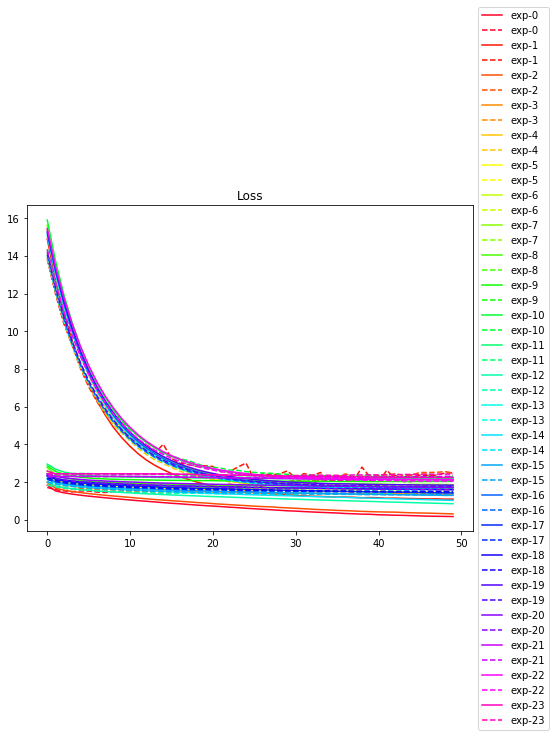

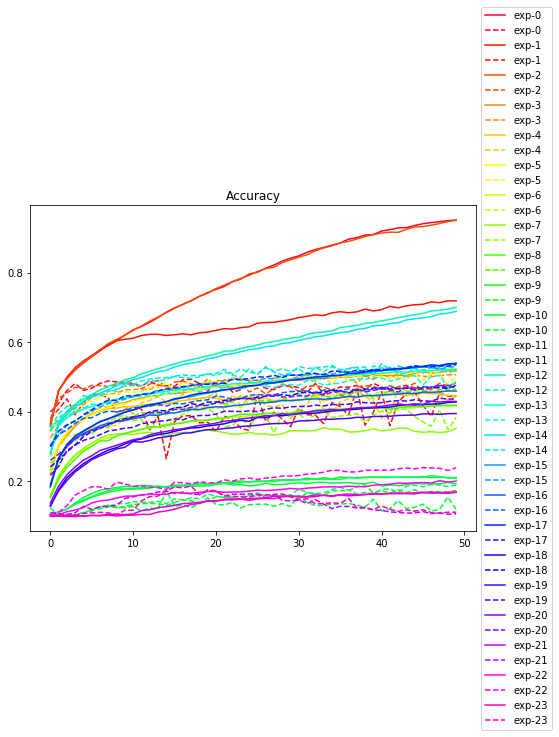

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

# 顏色數 要和前面的 嘗試參數組合數 一樣
NUM_COLORS = 24
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

# plot
# loss
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# acc
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()